### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

2.1.0+cu118


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = (img / 255) * 2 - 1
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)

    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
all_img = np.concatenate([train_img, test_img], axis=0)
all_label = np.concatenate([train_label, test_label], axis=0)

target_idx = 3
target_img = all_img[all_label==target_idx]
target_label = all_label[all_label==target_idx]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 512

train_dataset = MNIST_Dataset(target_img, target_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([512, 28, 28])
torch.Size([512])


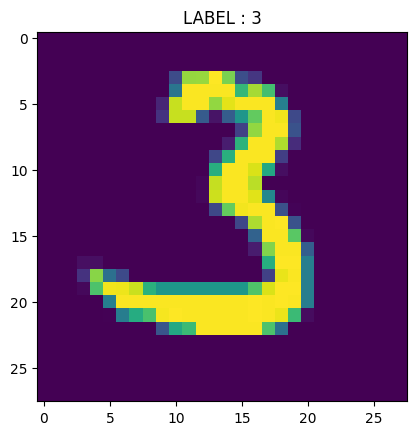

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the VAE (encoder + decoder)
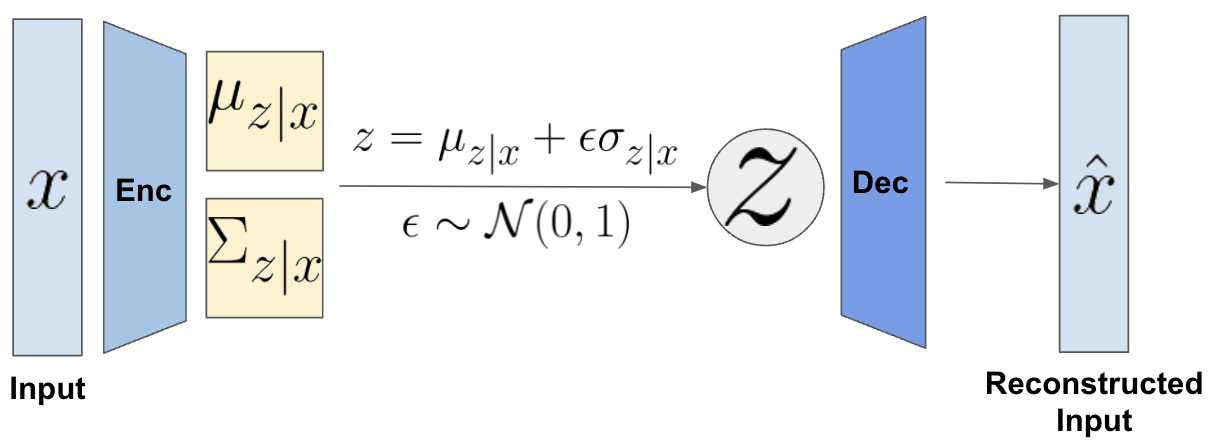

In [ ]:
class VAE(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(VAE, self).__init__()

        # define hidden dimension for encoder and decoder
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input
        # self.dim_output = dim_input

        # define encoder
        # light blue enc.
        self.enc_1 = nn.Linear(dim_input, dim_hidden_1)
        self.enc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)

        # two yellow blocks next to enc.
        self.enc_z_mean = nn.Linear(dim_hidden_2, dim_z)
        self.enc_z_logvar = nn.Linear(dim_hidden_2, dim_z)

        # define decoder
        self.dec_1 = nn.Linear(dim_z, dim_hidden_2)
        self.dec_2 = nn.Linear(dim_hidden_2, dim_hidden_1)
        self.dec_3 = nn.Linear(dim_hidden_1, dim_input)

        self.activation = nn.ReLU()

    def encoder(self, img):
        # img : B X H X W -> B X HW
        batch_size = img.shape[0] # B
        input = img.view(batch_size, -1)

        tmp_z = self.activation(self.enc_1(input))
        tmp_z = self.activation(self.enc_2(tmp_z))
        z_mean = self.enc_z_mean(tmp_z)
        z_logvar = self.enc_z_logvar(tmp_z)

        return z_mean, z_logvar

    def sampling(self, mean, logvar):
        std = torch.exp(0.5*logvar) # exp(0.5*Log(sigma^2)) = sigma.
        eps = torch.randn_like(std) # dim_z dimensional vec.
        z_sample = torch.mul(eps, std) + mean
        return z_sample

    def decoder(self, z_sample):
        out = self.activation(self.dec_1(z_sample))
        out = self.activation(self.dec_2(out))

        out = torch.tanh(self.dec_3(out))
        return out

    def forward(self, img):
        z_mean, z_logvar = self.encoder(img)
        z_sample = self.sampling(z_mean, z_logvar)
        # self.decoder(z_sample)-> reconstruction loss function
        # z_mean, z_logvar :  to calculate KL term in loss.
        return self.decoder(z_sample), z_mean, z_logvar

### Define the Model

In [ ]:
dim_hidden_1 = 512
dim_hidden_2 = 256
dim_z = 128
model = VAE(dim_hidden_1, dim_hidden_2, dim_z)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

VAE(
  (enc_1): Linear(in_features=784, out_features=512, bias=True)
  (enc_2): Linear(in_features=512, out_features=256, bias=True)
  (enc_z_mean): Linear(in_features=256, out_features=128, bias=True)
  (enc_z_logvar): Linear(in_features=256, out_features=128, bias=True)
  (dec_1): Linear(in_features=128, out_features=256, bias=True)
  (dec_2): Linear(in_features=256, out_features=512, bias=True)
  (dec_3): Linear(in_features=512, out_features=784, bias=True)
  (activation): ReLU()
)


#### Note that the KL dirvergence $D_{KL}(q_\phi(z|x^{(i)})\|p_\theta(z))$ is calculated as
#### -$\frac{1}{2}\sum_{j=1}^{J}\Big( 1 + \log((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \Big)$

In [ ]:
def criterion(recon_img, img, z_mean, z_logvar):
    MSE_loss = nn.MSELoss(reduction='mean')(recon_img, img.view(-1, img_size**2))
    KL_loss = -0.5 * torch.mean(1 + z_logvar - z_mean**2 - torch.exp(z_logvar))
    coeff = 1.0
    return MSE_loss + coeff * KL_loss

### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()
    optimizer.zero_grad()

    img = sample['img'].float().to(device)

    recon_img, z_mean, z_logvar = model(img)

    curr_loss = criterion(recon_img, img, z_mean, z_logvar)

    curr_loss.backward()
    optimizer.step()

    return curr_loss.item()

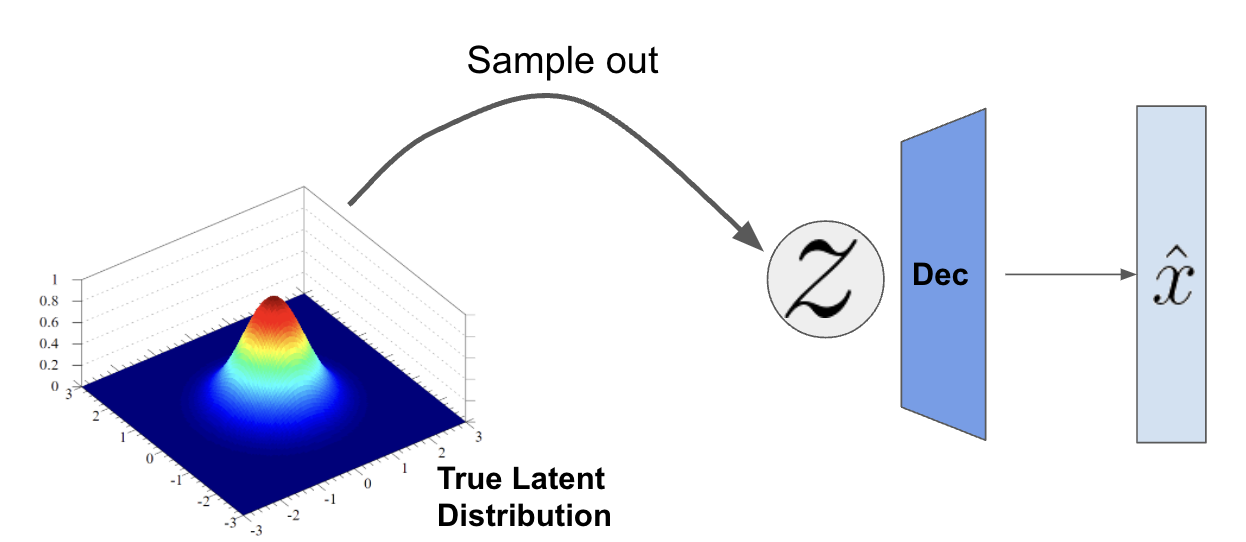

In [ ]:
def test(model, seed=0):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(seed)
        z_sample = torch.randn(1, dim_z).to(device)
        gen_out = model.decoder(z_sample)

    return gen_out.view(img_size, img_size).detach().cpu().numpy()

### Run Training

  0%|          | 0/100 [00:00<?, ?it/s]

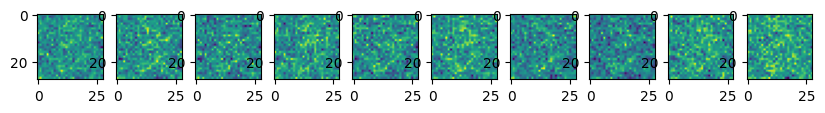

[EPOCH 0] SAMPLED TRAINING LOSS : 0.9089744091033936
[EPOCH 1] SAMPLED TRAINING LOSS : 0.8542148570219676
[EPOCH 2] SAMPLED TRAINING LOSS : 0.7930103441079458
[EPOCH 3] SAMPLED TRAINING LOSS : 0.7173837721347809
[EPOCH 4] SAMPLED TRAINING LOSS : 0.6227846244970957


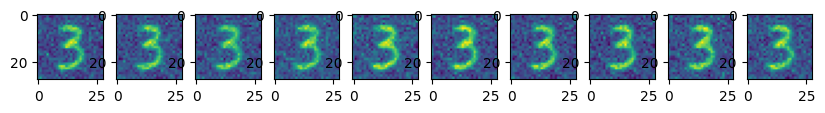

[EPOCH 5] SAMPLED TRAINING LOSS : 0.5157029032707214
[EPOCH 6] SAMPLED TRAINING LOSS : 0.41781605780124664
[EPOCH 7] SAMPLED TRAINING LOSS : 0.3445626894632975
[EPOCH 8] SAMPLED TRAINING LOSS : 0.30024802188078564
[EPOCH 9] SAMPLED TRAINING LOSS : 0.27445028225580853


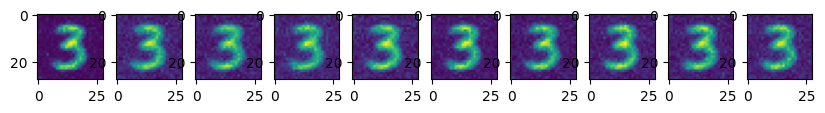

[EPOCH 10] SAMPLED TRAINING LOSS : 0.26016269624233246
[EPOCH 11] SAMPLED TRAINING LOSS : 0.2517617642879486
[EPOCH 12] SAMPLED TRAINING LOSS : 0.24560815344254175
[EPOCH 13] SAMPLED TRAINING LOSS : 0.2421974539756775
[EPOCH 14] SAMPLED TRAINING LOSS : 0.2395586371421814


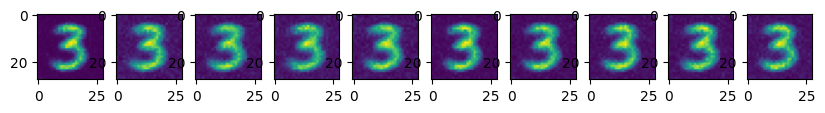

[EPOCH 15] SAMPLED TRAINING LOSS : 0.23777153342962265
[EPOCH 16] SAMPLED TRAINING LOSS : 0.23646242916584018
[EPOCH 17] SAMPLED TRAINING LOSS : 0.2347870742281278
[EPOCH 18] SAMPLED TRAINING LOSS : 0.23408756156762442
[EPOCH 19] SAMPLED TRAINING LOSS : 0.23330082992712653


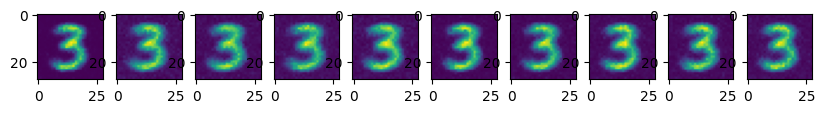

[EPOCH 20] SAMPLED TRAINING LOSS : 0.2326451713840167
[EPOCH 21] SAMPLED TRAINING LOSS : 0.23219932367404303
[EPOCH 22] SAMPLED TRAINING LOSS : 0.23126436273256937
[EPOCH 23] SAMPLED TRAINING LOSS : 0.23105550557374957
[EPOCH 24] SAMPLED TRAINING LOSS : 0.23069820056358972


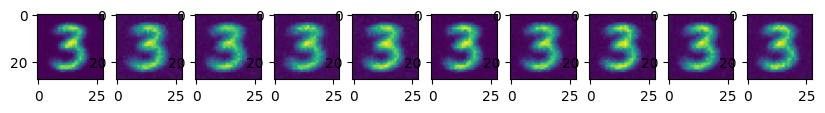

[EPOCH 25] SAMPLED TRAINING LOSS : 0.23032026986281076
[EPOCH 26] SAMPLED TRAINING LOSS : 0.2301551103591919
[EPOCH 27] SAMPLED TRAINING LOSS : 0.22953025996685025
[EPOCH 28] SAMPLED TRAINING LOSS : 0.22951394816239676
[EPOCH 29] SAMPLED TRAINING LOSS : 0.22934932510058087


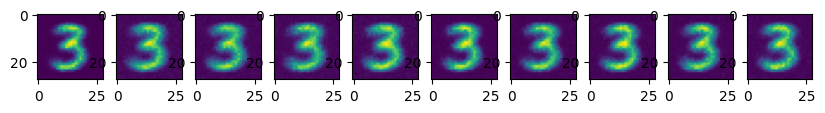

[EPOCH 30] SAMPLED TRAINING LOSS : 0.22908085336287815
[EPOCH 31] SAMPLED TRAINING LOSS : 0.22902632753054303
[EPOCH 32] SAMPLED TRAINING LOSS : 0.22854608794053394
[EPOCH 33] SAMPLED TRAINING LOSS : 0.22861043860514957
[EPOCH 34] SAMPLED TRAINING LOSS : 0.22853259990612668


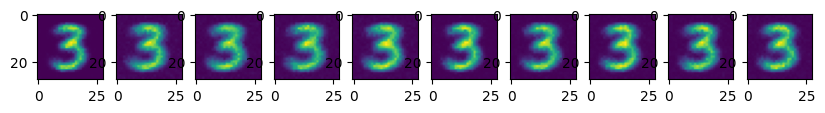

[EPOCH 35] SAMPLED TRAINING LOSS : 0.228291022280852
[EPOCH 36] SAMPLED TRAINING LOSS : 0.22827481975158057
[EPOCH 37] SAMPLED TRAINING LOSS : 0.2278609375158946
[EPOCH 38] SAMPLED TRAINING LOSS : 0.2279572735230128
[EPOCH 39] SAMPLED TRAINING LOSS : 0.227922777334849


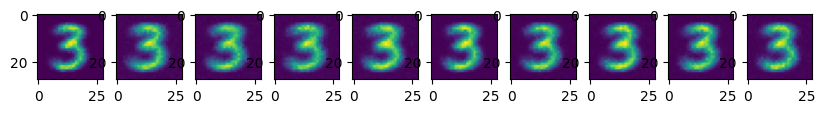

[EPOCH 40] SAMPLED TRAINING LOSS : 0.22766687224308652
[EPOCH 41] SAMPLED TRAINING LOSS : 0.22766032566626865
[EPOCH 42] SAMPLED TRAINING LOSS : 0.22727344930171967
[EPOCH 43] SAMPLED TRAINING LOSS : 0.22737645109494528
[EPOCH 44] SAMPLED TRAINING LOSS : 0.2273624911904335


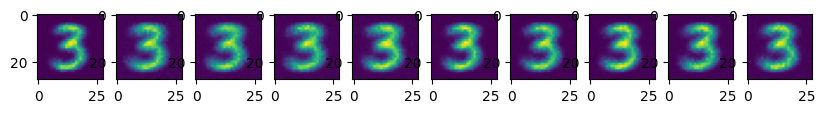

[EPOCH 45] SAMPLED TRAINING LOSS : 0.22705912838379538
[EPOCH 46] SAMPLED TRAINING LOSS : 0.2270461196700732
[EPOCH 47] SAMPLED TRAINING LOSS : 0.2266553888718287
[EPOCH 48] SAMPLED TRAINING LOSS : 0.22674044966697693
[EPOCH 49] SAMPLED TRAINING LOSS : 0.2267313500245412


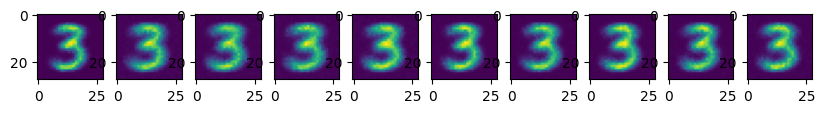

[EPOCH 50] SAMPLED TRAINING LOSS : 0.2263348201910655
[EPOCH 51] SAMPLED TRAINING LOSS : 0.22628860423962274
[EPOCH 52] SAMPLED TRAINING LOSS : 0.2258529216051102
[EPOCH 53] SAMPLED TRAINING LOSS : 0.22587635616461438
[EPOCH 54] SAMPLED TRAINING LOSS : 0.22583937148253122


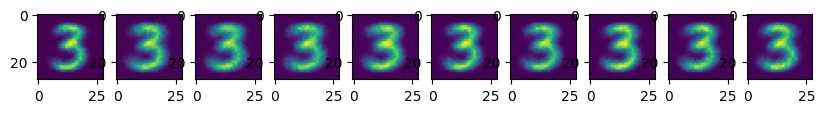

[EPOCH 55] SAMPLED TRAINING LOSS : 0.2252496580282847
[EPOCH 56] SAMPLED TRAINING LOSS : 0.2250920683145523
[EPOCH 57] SAMPLED TRAINING LOSS : 0.22450769692659378
[EPOCH 58] SAMPLED TRAINING LOSS : 0.22434364010890326
[EPOCH 59] SAMPLED TRAINING LOSS : 0.22416263073682785


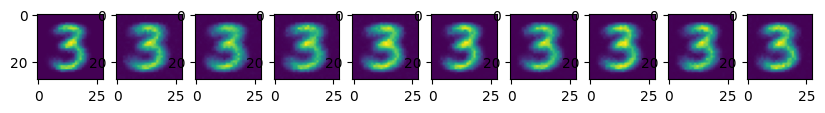

[EPOCH 60] SAMPLED TRAINING LOSS : 0.22311094403266907
[EPOCH 61] SAMPLED TRAINING LOSS : 0.22261001418034235
[EPOCH 62] SAMPLED TRAINING LOSS : 0.221589595079422
[EPOCH 63] SAMPLED TRAINING LOSS : 0.22096585979064307
[EPOCH 64] SAMPLED TRAINING LOSS : 0.2204007531205813


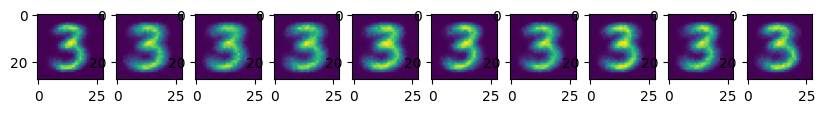

[EPOCH 65] SAMPLED TRAINING LOSS : 0.21855458865563074
[EPOCH 66] SAMPLED TRAINING LOSS : 0.2176520004868507
[EPOCH 67] SAMPLED TRAINING LOSS : 0.21627973268429437
[EPOCH 68] SAMPLED TRAINING LOSS : 0.2156228100260099
[EPOCH 69] SAMPLED TRAINING LOSS : 0.21531537423531213


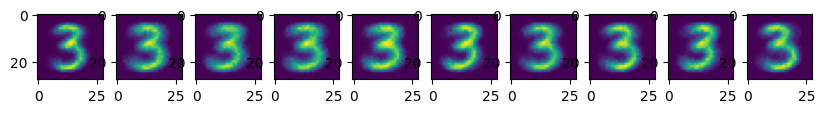

[EPOCH 70] SAMPLED TRAINING LOSS : 0.21344355742136636
[EPOCH 71] SAMPLED TRAINING LOSS : 0.21288868784904477
[EPOCH 72] SAMPLED TRAINING LOSS : 0.21188804507255554
[EPOCH 73] SAMPLED TRAINING LOSS : 0.21163670967022577
[EPOCH 74] SAMPLED TRAINING LOSS : 0.21188858151435852


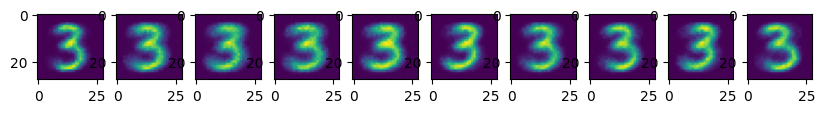

[EPOCH 75] SAMPLED TRAINING LOSS : 0.20999557028214133
[EPOCH 76] SAMPLED TRAINING LOSS : 0.20957478384176892
[EPOCH 77] SAMPLED TRAINING LOSS : 0.20876762022574744
[EPOCH 78] SAMPLED TRAINING LOSS : 0.20860934754212695
[EPOCH 79] SAMPLED TRAINING LOSS : 0.2090497389435768


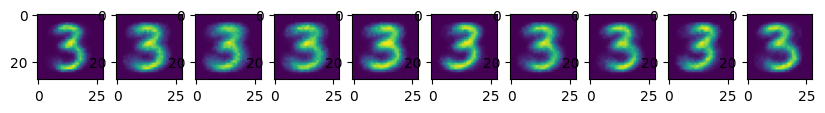

[EPOCH 80] SAMPLED TRAINING LOSS : 0.20709187785784403
[EPOCH 81] SAMPLED TRAINING LOSS : 0.20678474754095078
[EPOCH 82] SAMPLED TRAINING LOSS : 0.20608521501223245
[EPOCH 83] SAMPLED TRAINING LOSS : 0.20587060103813806
[EPOCH 84] SAMPLED TRAINING LOSS : 0.20645834505558014


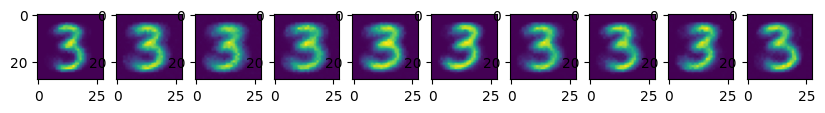

[EPOCH 85] SAMPLED TRAINING LOSS : 0.2045076141754786
[EPOCH 86] SAMPLED TRAINING LOSS : 0.2042209878563881
[EPOCH 87] SAMPLED TRAINING LOSS : 0.20351517448822656
[EPOCH 88] SAMPLED TRAINING LOSS : 0.20328383892774582
[EPOCH 89] SAMPLED TRAINING LOSS : 0.20397244890530905


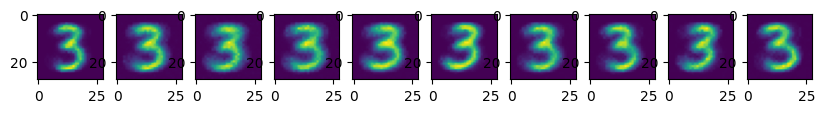

[EPOCH 90] SAMPLED TRAINING LOSS : 0.20197485635677975
[EPOCH 91] SAMPLED TRAINING LOSS : 0.2016587903102239
[EPOCH 92] SAMPLED TRAINING LOSS : 0.20100679993629456
[EPOCH 93] SAMPLED TRAINING LOSS : 0.2008302907148997
[EPOCH 94] SAMPLED TRAINING LOSS : 0.20157119631767273


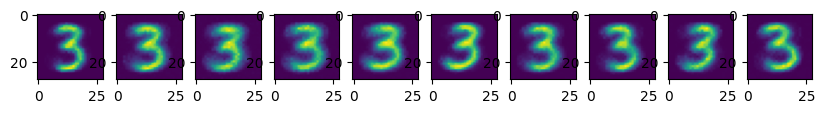

[EPOCH 95] SAMPLED TRAINING LOSS : 0.19958367943763733
[EPOCH 96] SAMPLED TRAINING LOSS : 0.1994140644868215
[EPOCH 97] SAMPLED TRAINING LOSS : 0.19888241837422052
[EPOCH 98] SAMPLED TRAINING LOSS : 0.19876490533351895
[EPOCH 99] SAMPLED TRAINING LOSS : 0.1995793730020523


In [ ]:
max_epoch = 100

for epoch in tqdm(range(max_epoch)):
    ###Train Phase

    # Initialize Loss
    train_loss = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)

    if epoch % 5 == 0:
        fig, ax = plt.subplots(1, 10, figsize=(10, 3))
        for i in range(10):
            ax[i].imshow(test(model, seed=i))
        plt.pause(0.01)

    print('[EPOCH {}] SAMPLED TRAINING LOSS : {}'.format(epoch, train_loss))

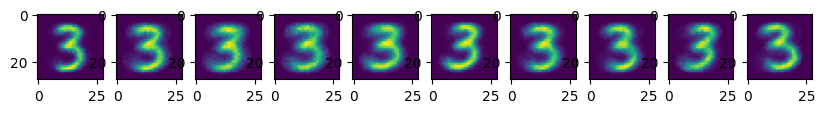

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(model, seed=i))